In [1]:
from captcha.image import ImageCaptcha
import numpy as np
from PIL import Image
import random
import sys
import os
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
number = [str(i) for i in range(10)]
little = [chr(i) for i in range(97,123)]
large = [chr(i) for i in range(65,91)]
print(number)
print(little)
print(large)
CHAR_SET = number

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


### 生成验证码

In [5]:
# 随机生成4个字符
def random_captcha_text(char_set=number,captcha_size=4):
    return ''.join(random.choices(CHAR_SET,k=4))

# 生成字符对应的验证码
def gen_captcha_text_and_image(path):
    image_ = ImageCaptcha()
    captcha_text = random_captcha_text()
    captcha = image_.generate(captcha_text)
    image_.write(captcha_text, path + captcha_text + '.jpg')

path = 'captcha/images/'
num = 10000

if not os.path.exists(path):
    os.makedirs(path)
for i in range(num):
    gen_captcha_text_and_image(path)
    sys.stdout.write('\r>> Creating image %d/%d' % (i+1,num))
    sys.stdout.flush()
sys.stdout.write('\n')
sys.stdout.flush()

>> Creating image 10000/10000


### 生成tfrecord

In [2]:
_NUM_TEST = 500

_RANDOM_SEED = 2

DATA_DIR = 'captcha/images/'

TFRECORD_DIR = 'captcha/'

def _tfdata_exists(dataset_dir):
    for split_name in ['train','test']:
        tf_name = os.path.join(dataset_dir,split_name + '.tfrecord')
        if not tf.gfile.Exists(tf_name):
            return False
    return True

def _get_filenames(dataset_dir):
    captcha_names = []
    for filename in os.listdir(dataset_dir):
        path = os.path.join(dataset_dir, filename)
        captcha_names.append(path)
    return captcha_names

def int64_feature(values):
    if not isinstance(values, (tuple, list)):
        values = [values]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=values))

def bytes_feature(values):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value = [values]))

def image_to_tfexample(image_data,label0,label1,label2,label3):
    return tf.train.Example(features=tf.train.Features(feature={
     'image': bytes_feature(image_data),
        'label0':int64_feature(label0),
        'label1':int64_feature(label1),
        'label2':int64_feature(label2),
        'label3':int64_feature(label3)
    }))

# 数据转换为record格式
def _convert_dataset(split_name, filenames, tfrecord_dir):
    assert split_name in ['train','test']
    
    with tf.Session() as sess:
        out_tfnames = os.path.join(tfrecord_dir, split_name + '.tfrecord')
        with tf.python_io.TFRecordWriter(out_tfnames) as tf_writer:
            for i,filename in enumerate(filenames):
                try:
                    sys.stdout.write('\r>> Converting image %d/%d' % (i+1,len(filenames)))
                    sys.stdout.flush()
                    
                    image_data = Image.open(filename)
                    image_data = image_data.resize((224,224))
                    image_data = image_data.convert('L').tobytes()
                    
                    # 拿到4位验证码并encode()
                    labels = filename.split('/')[-1][:4]
                    
                    example = image_to_tfexample(image_data, int(labels[0]), int(labels[1]), int(labels[2]), int(labels[3]))
                    tf_writer.write(example.SerializeToString())
                
                except IOError as e:
                    print('Wrong: ' + filename)
                    print('Error: ',e)
                    print('Skip it\n')
    sys.stdout.write('\n')
    sys.stdout.flush()
    
if _tfdata_exists(TFRECORD_DIR):
    print('tf文件已存在')
else:
    photo_filenames = _get_filenames(DATA_DIR)
    
    random.seed(_RANDOM_SEED)
    # 打乱文件
    random.shuffle(photo_filenames)
    training_filenames = photo_filenames[_NUM_TEST:]
    testing_filenames = photo_filenames[:_NUM_TEST]
    
    _convert_dataset('train', training_filenames, TFRECORD_DIR)
    _convert_dataset('test', testing_filenames, TFRECORD_DIR)

>> Converting image 5831/5831
>> Converting image 500/500


## 查看自己转换的是否正确

In [5]:
# 定义一个解读函数
def read_and_decode(filename_quene, batch_size, shuffle_batch=True):
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_quene)
    features = tf.parse_single_example(serialized_example,
                                      features={
                                          'image':tf.FixedLenFeature([], tf.string),
                                          'label0':tf.FixedLenFeature([], tf.int64),
                                          'label1':tf.FixedLenFeature([], tf.int64),
                                          'label2':tf.FixedLenFeature([], tf.int64),
                                          'label3':tf.FixedLenFeature([], tf.int64)
                                      })
    image = tf.decode_raw(features['image'], tf.int8)
    image = tf.reshape(image, [224,224])
    label0 = tf.cast(features['label0'], tf.int32)
    label1 = tf.cast(features['label1'], tf.int32)
    label2 = tf.cast(features['label2'], tf.int32)
    label3 = tf.cast(features['label3'], tf.int32)
    
# 随机抽取数据的代码应该写在函数外面，否则每抽取一次数据，就要载入一次tfrecord文件，会报异常
#     if shuffle_batch:
#         images, labels0, labels1, labels2, labels3 = tf.train.shuffle_batch([image, label0, label1, label2, label3],
#                                                batch_size=batch_size,
#                                                capacity=100,
#                                                num_threads=4,
#                                                min_after_dequeue=20)
#     else:
#         images, labels0, labels1, labels2, labels3 = tf.train.batch([image, label0, label1, label2, label3],
#                                         batch_size=batch_size,
#                                         capacity=100,
#                                         num_threads=4,
#                                         min_after_dequeue=20)
    return image, label0, label1, label2, label3

In [6]:
def show_tfrecord(tf_name, batch_num,batch_size):
    filename_queue = tf.train.string_input_producer([tf_name])
    images, labels0, labels1, labels2, labels3 = read_and_decode(filename_queue,batch_size)
    images_b, labels0_b, labels1_b, labels2_b, labels3_b = tf.train.shuffle_batch([images, labels0, labels1, labels2, labels3],
                                                                                   batch_size=batch_size,
                                                                                   capacity=100,
                                                                                   num_threads=1,
                                                                                   min_after_dequeue=20)
    init_op = tf.group(tf.global_variables_initializer(),
                      tf.local_variables_initializer())
    with tf.Session() as sess:
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        
        for i in range(batch_num):
            img_, label0_, label1_, label2_, label3_ = sess.run([images_b, labels0_b, labels1_b, labels2_b, labels3_b])
            print('batch' + str(i) + ':')
            for j in range(batch_size):
                print(label0_[j],label1_[j],label2_[j],label3_[j])
                plt.imshow(img_[j],cmap='gray')
                plt.show()
        coord.request_stop()
        coord.join(threads)

batch0:
3 3 5 2


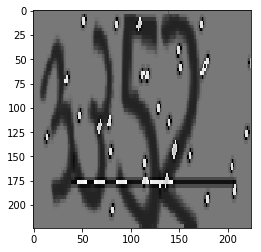

5 2 2 5


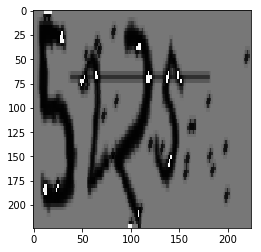

0 2 7 7


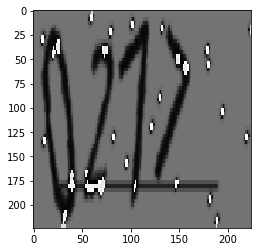

batch1:
8 5 1 7


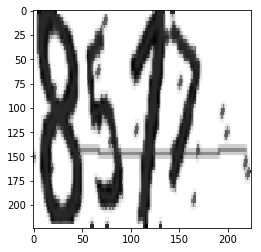

9 9 2 0


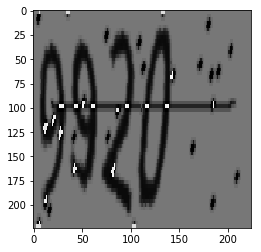

5 1 4 2


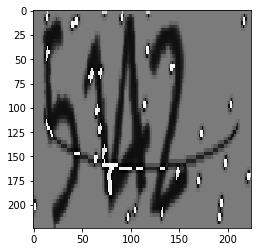

batch2:
9 0 2 8


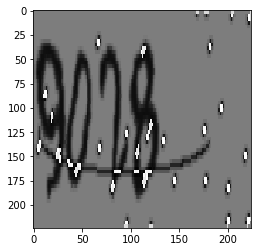

3 8 9 5


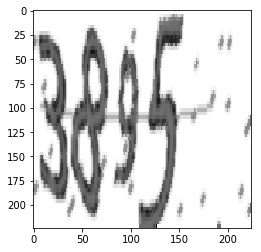

6 8 6 3


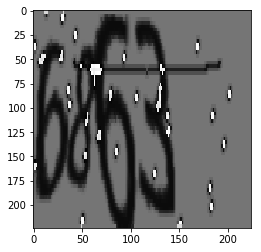

In [7]:
show_tfrecord('captcha/train.tfrecord',batch_num=3,batch_size=3)

batch0:
9 4 7 9


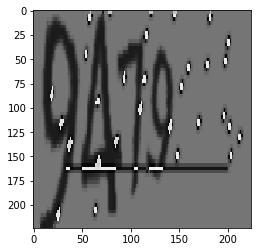

6 7 2 9


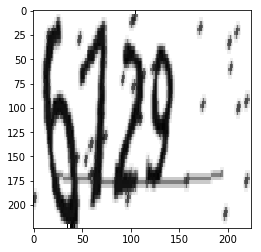

2 9 5 6


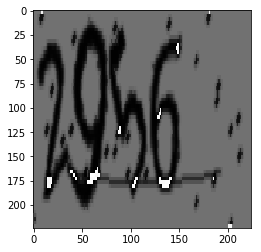

batch1:
7 2 9 2


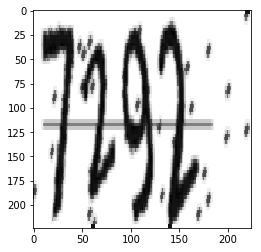

6 6 2 1


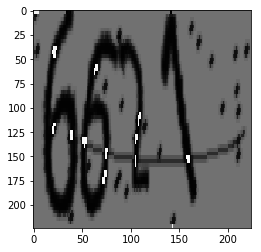

2 2 3 5


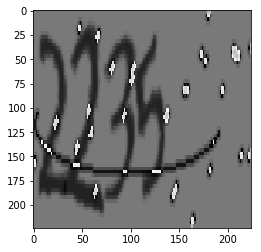

batch2:
6 9 6 0


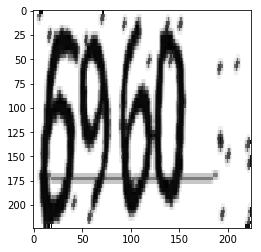

8 7 8 2


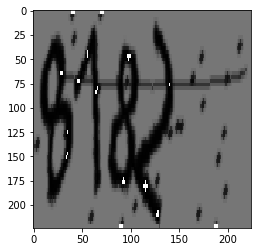

7 7 6 9


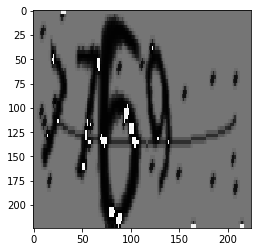

In [8]:
show_tfrecord('captcha/test.tfrecord', batch_num=3, batch_size=3)